Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73

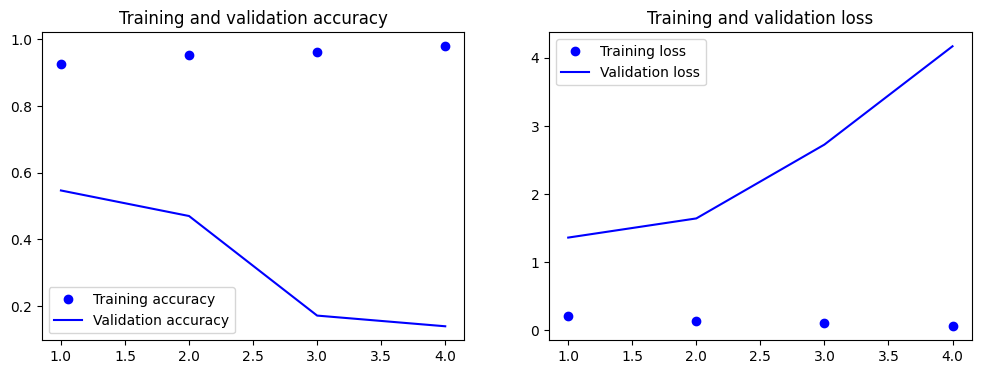

In [7]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from PIL import UnidentifiedImageError, Image

# Mount Google Drive
drive.mount('/content/drive')

# Set directories
train_dir = '/content/drive/My Drive/training_2/Training'
test_dir = '/content/drive/My Drive/Testing'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Custom preprocessing function to handle unidentifiable images
def preprocess_input(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize((img_height, img_width))
        img = np.array(img) / 255.0
        if img.shape == (img_height, img_width, 3):  # Ensure the image has the correct shape
            return img
        else:
            return None
    except UnidentifiedImageError:
        return None

# Custom data generator to handle bad images
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, img_height, img_width, class_mode='binary', shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.datagen = ImageDataGenerator()
        self.filepaths, self.labels = self._load_filepaths_and_labels()
        self.on_epoch_end()

    def _load_filepaths_and_labels(self):
        filepaths = []
        labels = []
        classes = os.listdir(self.directory)
        for class_index, class_name in enumerate(classes):
            class_dir = os.path.join(self.directory, class_name)
            for filename in os.listdir(class_dir):
                filepath = os.path.join(class_dir, filename)
                filepaths.append(filepath)
                labels.append(class_index)
        return filepaths, labels

    def __len__(self):
        return len(self.filepaths) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.filepaths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_filepaths = [self.filepaths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        images = []
        labels = []
        for filepath, label in zip(batch_filepaths, batch_labels):
            img = preprocess_input(filepath)
            if img is not None:
                images.append(img)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)

        return images, labels

# Create training and testing data generators
train_generator = CustomDataGenerator(
    train_dir,
    batch_size=batch_size,
    img_height=img_height,
    img_width=img_width,
    class_mode='binary'
)

test_generator = CustomDataGenerator(
    test_dir,
    batch_size=batch_size,
    img_height=img_height,
    img_width=img_width,
    class_mode='binary'
)

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=4,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc:.2f}')

# Plot training and validation accuracy/loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)


In [8]:
#save the model
model.save('model.h5')